In [23]:
import json
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
# Import the file with results
with open("results-RoBERTa/RoBERTa-main-classification-results.json") as results_file:
    results = json.load(results_file)

In [10]:
# Import one training file to get the labels.
train_df = pd.read_csv("G:\My Drive\GitHub\Cross-Lingual-and-Cross-Dataset-Experiments-with-Genre-Datasets\data\SI_GINCO_train.csv")
train_df.head()

,text,labels
0,PES - BITJE ZA OSAMLJENE? <p/> Življenje z živ...,Opinion/Argumentation
1,Predelne stene <p/> Pogosto se zgodi da pri gr...,Promotion
2,V Izoli se je končal 9. mednarodni turnir v go...,News
3,Okvirji za vaše plakate <p/> Pri naročilu okvi...,Instruction
4,"Bojijo se lakote <p/> Sto ekip, 30 evropskih m...",News


In [11]:
LABELS = list(train_df.labels.unique())
LABELS

['Opinion/Argumentation',
 'Promotion',
 'News',
 'Instruction',
 'Information/Explanation',
 'Legal/Regulation',
 'Review',
 'Research Article',
 'Forum',
 'Recipe',
 'Prose',
 'Interview']

In [13]:
# Calculate scores per labels and add this information to results
for instance in results:
    y_true = instance["y_true"]
    y_pred = instance["y_pred"]

    score_per_label = list(f1_score(y_true, y_pred, labels=LABELS, average=None))

    dict_score_per_label = {}

    for index in range(len(LABELS)):
        dict_score_per_label[LABELS[index]] = score_per_label[index]
        
    instance["scores_per_labels"] = dict_score_per_label

In [14]:
# Inspect the results as a dataframe
results_df = pd.DataFrame(results)
results_df.head()

,trained_on,tested_on,microF1,macroF1,y_true,y_pred,scores_per_labels
0,SL-GINCO,SL-GINCO,0.802469,0.734463,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Promotion, ...","{'Opinion/Argumentation': 0.5789473684210527, ..."
1,SL-GINCO,CORE,0.631191,0.536556,"[News, News, News, News, Information/Explanati...","[News, Promotion, News, News, Opinion/Argument...","{'Opinion/Argumentation': 0.5864618885096701, ..."
2,MT-GINCO,MT-GINCO,0.814815,0.869582,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Instruction...","{'Opinion/Argumentation': 0.6341463414634148, ..."
3,MT-GINCO,CORE,0.634434,0.536819,"[News, News, News, News, Information/Explanati...","[News, News, News, News, Opinion/Argumentation...","{'Opinion/Argumentation': 0.5953194846174072, ..."
4,CORE,CORE,0.768573,0.719598,"[News, News, News, News, Information/Explanati...","[News, News, News, News, Information/Explanati...","{'Opinion/Argumentation': 0.7313389485913447, ..."


C:\Users\TajaK\AppData\Local\Temp\ipykernel_19056\346382325.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


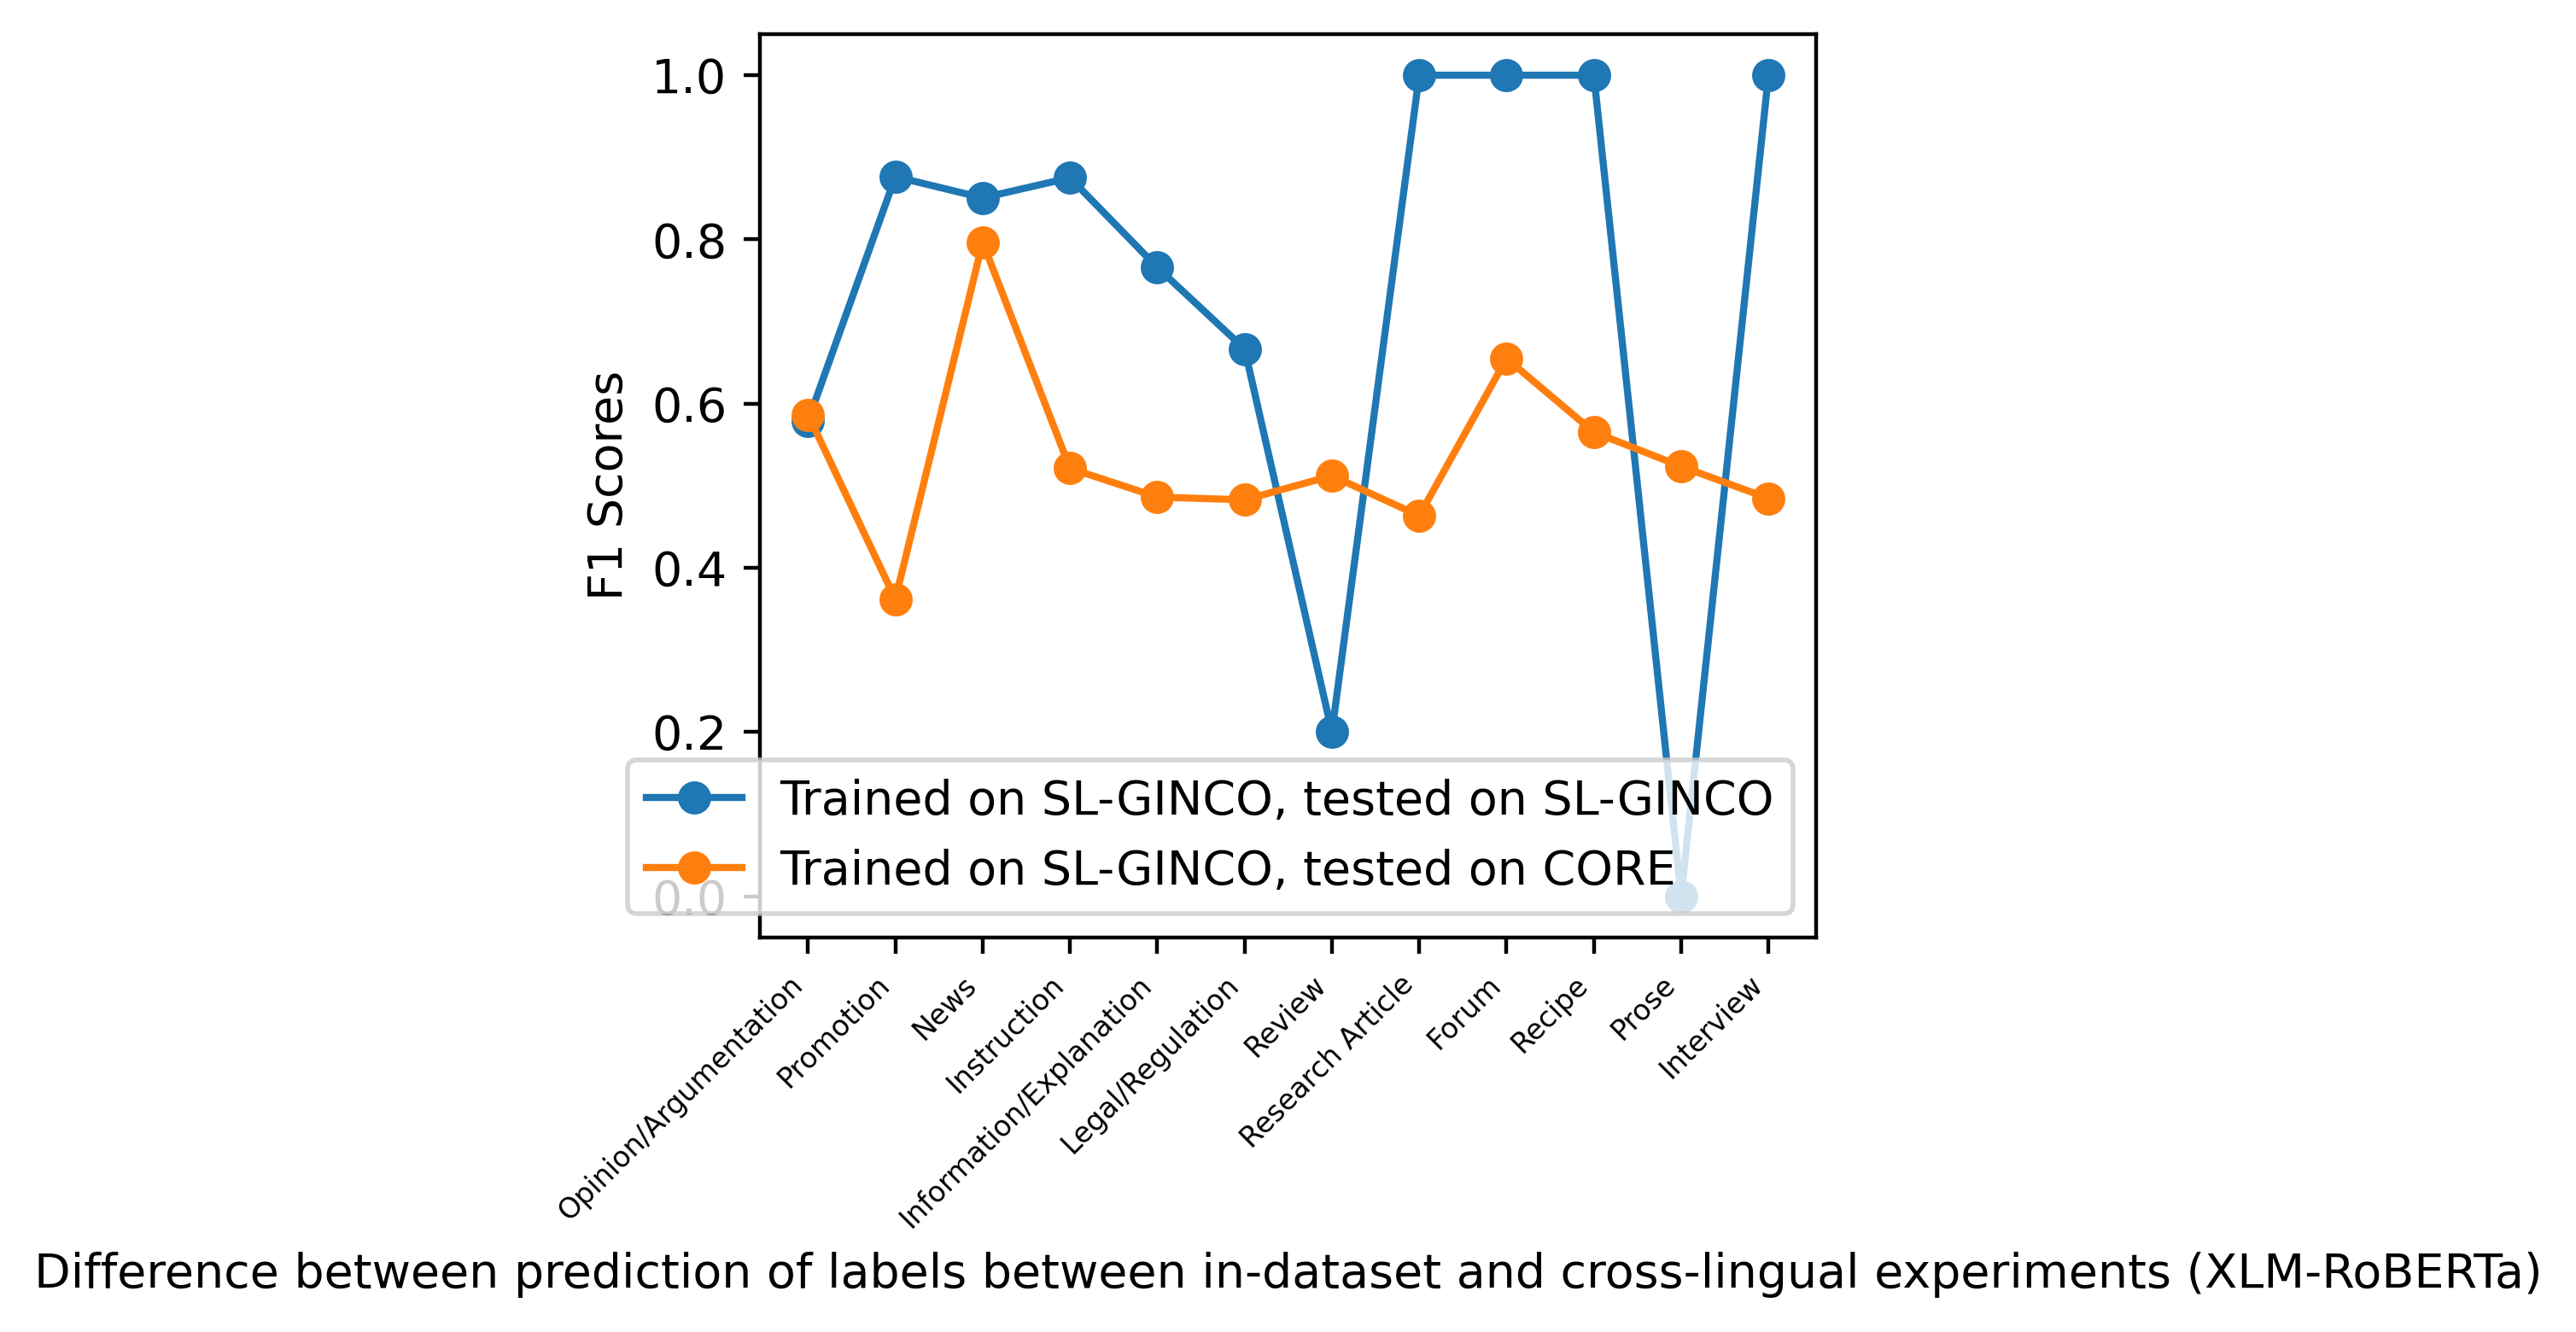

In [61]:
# Plot the differences between the label scores in different setups:
labels_names = LABELS

fig, ax = plt.subplots(figsize=(4,4), dpi=400)
for i in range(len(results)):
    current_i = results[i]
    trained_on = current_i["trained_on"]
    tested_on = current_i["tested_on"]
    if trained_on == "SL-GINCO" and tested_on in ["SL-GINCO", "CORE"]:
        plot_label = f"Trained on {trained_on}, tested on {tested_on}"
        x = list(current_i["scores_per_labels"].values())
        ax.errorbar(labels_names, x, fmt='-o', label=plot_label, capsize=3)

plt.xticks(fontsize=6)
ax.set_xlabel('Labels')
ax.set_ylabel('F1 Scores')
xlabels = LABELS
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(loc="lower right")
ax.set_xlabel("Difference between prediction of labels between in-dataset and cross-lingual experiments (XLM-RoBERTa)")
fig.tight_layout()
plt.savefig("results-RoBERTa\label-scores-SI-GINCO-indataset-vs-transfer-to-CORE.png")
plt.show()